# Dependencies

In [ ]:
!pip install datasets
!pip install transformers
!pip install huggingface_hub
!pip install setfit
!pip install spacytextblob

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# Introduction

This notebook contains rough outlines and explanations of each step. For a more detailed analysis of the model creation process, see the UniFeed technical specification.

**Goal:**Detecting political bias against entities in sentences


**How?:** Determine lexical bias using sentence transformers

Named entities like people, organizations, and locations are often the subjects of biased statements.

Adjectives play a crucial role in conveying sentiment, opinion, and bias.

Media bias by word choice rarely depends on context outside the sentences.

# Initial Datasets

**Dataset 1:** BABE
* Primary Dataset used in this model (political sentences from news articles manually curated by experts). It

**Dataset 2:** MBIB -The First Media Bias Identification Benchmark Task and Dataset Collection
* Secondary Dataset used to fill in gaps and imbalances in the first Dataset. I



**More info**

BABE Paper: https://aclanthology.org/2021.findings-emnlp.101/

MBIB Paper: https://dl.acm.org/doi/pdf/10.1145/3539618.3591882


In [ ]:
dataset = load_dataset("mediabiasgroup/BABE-v3")
dataset_2 = load_dataset("mediabiasgroup/mbib-base")

In [ ]:
dataset_2 = dataset_2['political_bias']

Global Variables

In [ ]:
# Figure Colours
fig1, fig2, fig3 = "#84A98C", "#BE95C4", "#BB9457"

# Seed to be used in random functions to make them deterministic and reproducible
RANDOM_SEED = 326

# Dataset Integration

First Dataset

In [ ]:
# Convert the HuggingFace dataset to pandas DataFrames
df = pd.DataFrame(dataset['train'])

# Drop the columns we do not need for out model ('text' is our feature, 'type' is our class. So the rest can go)
# I hardcode dropping each column to make it easy to see what data is being dropped
df.drop('news_link', axis=1, inplace=True)
df.drop('outlet', axis=1, inplace=True)
df.drop('topic', axis=1, inplace=True)
df.drop('label', axis=1, inplace=True)
df.drop('label_opinion', axis=1, inplace=True)
df.drop('biased_words', axis=1, inplace=True)

# Rename 'type' column to 'label' (standard column name for model training)
df.rename(columns={'type': 'label'}, inplace=True)

Second Dataset

In [ ]:
# Convert the HuggingFace dataset to pandas DataFrames
df2 = pd.DataFrame(dataset_2)

# This dataset has the text labeled 1 or 0 (biased or unbiased), it is political based, so 1 basically means Right OR Left bias
# Since we are only using this dataset for filling in missing Center classes, we only need text labeled 0 (No Right OR Left bias)
df2 = df2[df2['label'] == 0]
# Change all values from 0 to 'center' for compatibility with the primary Dataset
df2['label'] = 'center'

# Data Analysis

In [ ]:
df_analysis = df.copy()

Analyze the distribution on sentence lengths (in words)

In [ ]:
df_analysis['sentence_length'] = df_analysis['text'].apply(lambda x: len(x.split()))

In [ ]:
all_analysis = df_analysis['sentence_length'].describe()
display(all_analysis)

In [ ]:
# Create a histogram showing the distribution of all sentence lengths
plt.hist(df_analysis['sentence_length'], bins=10, edgecolor='black')
plt.title('Histogram of Sentence Lengths (in words)')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
display(df_analysis[df_analysis['sentence_length'] > 88])

In [ ]:
# Create a box plot showing all sentence lengths
plt.boxplot(df_analysis['sentence_length'])
plt.title('Box Plot of Sentence Lengths (in words)')
plt.ylabel('Sentence Length (in words)')
plt.xticks([1], ['Sentence Lengths'])
plt.show()

Analysis focused on sentences beloning to specific labels

In [ ]:
right_analysis = df_analysis[df_analysis['label'] == 'right']['sentence_length'].describe()
left_analysis = df_analysis[df_analysis['label'] == 'left']['sentence_length'].describe()
center_analysis = df_analysis[df_analysis['label'] == 'center']['sentence_length'].describe()

In [ ]:
display(all_analysis)

In [ ]:
display(right_analysis)
display(center_analysis)
display(left_analysis)

The sentence lengths look pretty good, there's no extreme skew. There are outliers but I do not feel comfortable removing them for 2 reasons:
1. There are very few of them and I want longer sentences to be represented in the dataset.
2. What if sentence length has a valid association to political bias. Currently both left and right sentence have a max of 80 and 99 respectively. Whereas Center has a max of 62. This could be a data issue, or it may be the case that biased sentences are typically longer (e.g. more adjectives?). Needs deeper research.


However, I do feel comfortable removing all sentences > 90 words or < 9 words from the second dataframe (the one I will use to fill in missing center entries when balancing the data). That will guarantee that it does not introduce a skew to the first dataset. There is no need to individually analyze the second dataset, as long as it conforms to the range of the first one, that's all that matters.


In [ ]:
# This shows that the '1' min of center is a single entry data error and can be removed in the cleaning to bring it's min to 9 (in line with left and right)
display(df_analysis[df_analysis['label'] == 'center'].sort_values('sentence_length'))

# Dataset Cleaning

Before Cleaning

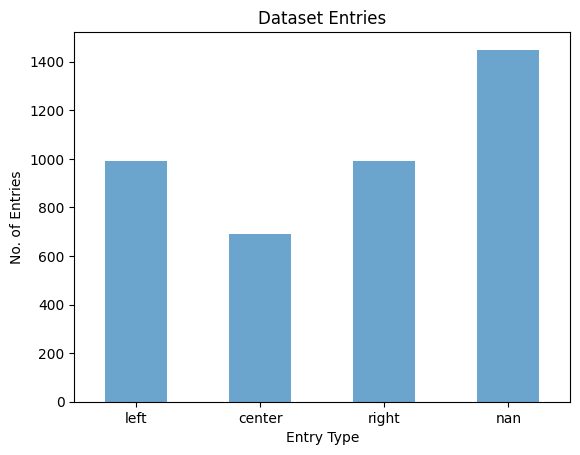

After Cleaning

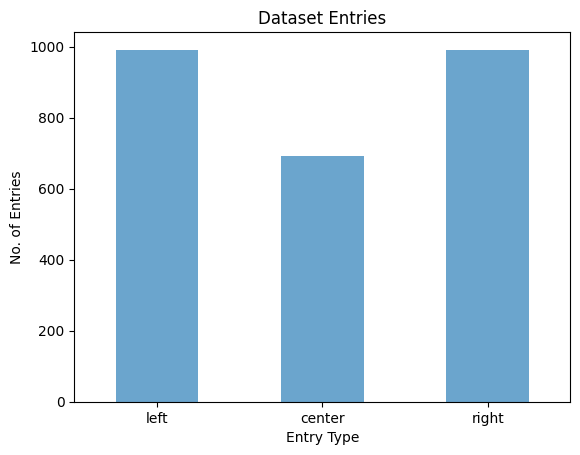

In [ ]:
# I like to make a copy of the dataframe to use in each different section so I can easily revert changes if necessary
# DataFrame checkpoint
clean_df = df.copy()
clean_df2 = df2.copy()

In [ ]:
counts = clean_df['label'].value_counts()

desired_order = ['left', 'center', 'right']

# Make the bar chart order: Left, Center, Right but also include any extra values, e.g NaN
ordered_counts = counts.reindex(desired_order + [x for x in counts.index if x not in desired_order])

ordered_counts.plot(kind='bar', alpha=0.66)

plt.title('Dataset Entries')
plt.xlabel('Entry Type')
plt.ylabel('No. of Entries')
plt.xticks(rotation=0)

plt.show()

Remove rows with missing values

In [ ]:
# Filter out nan political labels
print("Before:", len(clean_df))
clean_df = clean_df[clean_df['label'] != 'nan']
print("After:", len(clean_df))

Merge duplicate entries

In [ ]:
print("Before:", len(clean_df))
clean_df.drop_duplicates(keep='first', inplace=True)
print("After:", len(clean_df))

Filter out rows in df2 where 'text' is None

In [ ]:
clean_df2 = clean_df2[clean_df2['text'].notna()]

Remove entries in df2 that have the same text as df1 (since df2 is filling in df1 gaps, we do not want duplicates coming over in the case of content overlap)

In [ ]:
print("Before:", len(clean_df2))
clean_df2 = clean_df2[~clean_df2['text'].isin(clean_df['text'])]
print("After:", len(clean_df2))

Drop duplicates for df2

In [ ]:
print("Before:", len(clean_df2))
clean_df2.drop_duplicates(keep='first', inplace=True)
print("After:", len(clean_df2))

Remove entries outside of expected word length. See comments or Data Analysis section for more information.



In [ ]:
clean_df2

In [ ]:
# This removes only 1 entry and brings the min of the dataset from 1 to 9.
# The removed entry is a data error for the center class discovered in the dataset analysis section.
print("Before:", len(clean_df))
clean_df = clean_df[clean_df['text'].str.split().apply(len) > 8]
clean_df = clean_df[clean_df['text'].str.split().apply(len) < 90]
print("After:", len(clean_df))

In [ ]:
# This ensures that the second dataset (the one used to fill missing center entries in data balancing later) falls within
# the same range as the first dataset (8-90 words). 1407 entries from df2 are lost here, so this is quite crucial for cleaning
# the second dataset to be a good donor for the first first dataset.
clean_df2 = clean_df2[clean_df2['text'].str.split().apply(len) > 8]
clean_df2 = clean_df2[clean_df2['text'].str.split().apply(len) < 90]

In [ ]:
clean_df2

In [ ]:
# Push section changes to global df
df = clean_df
df2 = clean_df2

# Dataset Balancing

In [ ]:
# Dataframe checkpoints
balanced_df = df.copy()
balanced_df2 = df2.copy()

In [ ]:
# Sample 297 center entries from df2, 297 is the difference between the current center entry count and the median
random_center_sample = balanced_df2.sample(n=297, random_state=RANDOM_SEED)

balanced_df = pd.concat([balanced_df, random_center_sample], ignore_index=True)

In [ ]:
type_counts = balanced_df['label'].value_counts()

In [ ]:
# Data
categories = ['left', 'center', 'right']
counts = [type_counts['left'], type_counts['center'], type_counts['right']]

# Creating the bar chart
plt.figure(figsize=(8, 5))
plt.bar(categories, counts, color=[fig1, fig2, fig3])
plt.title('Sentence Count Per Label')
plt.xlabel('Label')
plt.ylabel('Count')

# Get the mean and median
mean_occurrences = np.mean(type_counts)
median_occurrences = np.median(type_counts)

# Add the mean and median lines (red and green respectively)
plt.axhline(y=mean_occurrences, color='r', linestyle='-', label=f'Mean: {mean_occurrences:.2f}')
plt.axhline(y=median_occurrences, color='g', linestyle='--', label=f'Median: {median_occurrences:.2f}')
plt.legend(loc=4)

plt.show()

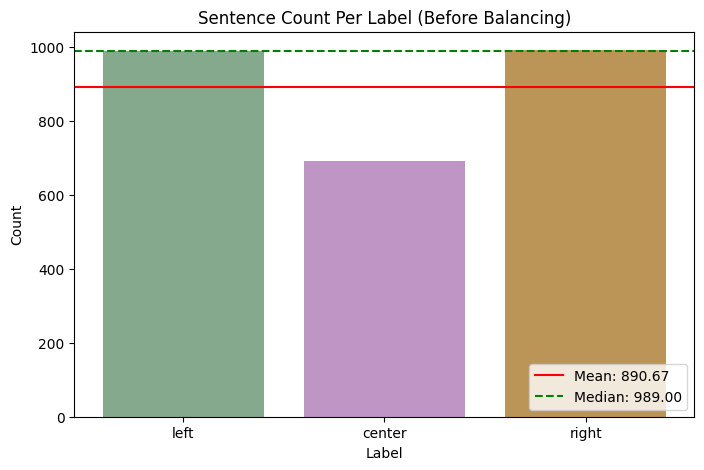

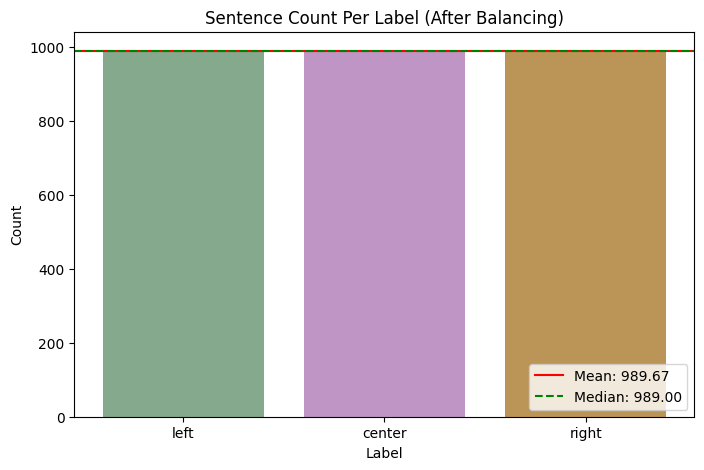

In [ ]:
# Push section changes to global df
df = balanced_df

# Advanced Anaylsis

At this point the 'final' dataset has been created.

This section is to further analyse the dataset and determine the characteristics of its content. The findings here will inform how the dataset can be expanded upon and updated in the future. In addition to this, it will be extremely helpful in learning what the dataset is trained with (biases, limitations) so that the input data for the model can be carefully selected to fit within the constraints of the dataset.

 For example, it could be that 90% of the dataset sentences contain an adjective, and if that's the case, it'd be safer to treat this model as 'detecting political bias in sentences with adjectives' and when selecting what text to predict bias in, we should aim for one with adjectives.


**Libraries used**
*   SpaCy
*   TextBlob


In [ ]:
from textblob import TextBlob
import spacy
from IPython.display import Markdown # For generating markdown tables
from matplotlib_venn import venn3

nlp = spacy.load("en_core_web_sm")

In [ ]:
df_adv = df.copy()

In [ ]:
# calculate polarity and subjectivity
def calculate_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply the function to each row
df_adv['polarity'], df_adv['subjectivity'] = zip(*df_adv['text'].apply(calculate_sentiment))

In [ ]:
def get_nlp_metrics(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    entity_labels = [ent.label_ for ent in doc.ents]
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    return entities, entity_labels, adjectives

# Assign the results to new columns in the DataFrame
df_adv['entities'], df_adv['entity_labels'], df_adv['adjectives'] = zip(*df_adv['text'].apply(get_nlp_metrics))

In [ ]:
df_left = df_adv[df_adv['label'] == 'left']
df_center = df_adv[df_adv['label'] == 'center']
df_right =df_adv[df_adv['label'] == 'right']

In [ ]:
left_entities = df_left[df_left['entities'].apply(lambda x: len(x) > 0)]
center_entities = df_center[df_center['entities'].apply(lambda x: len(x) > 0)]
right_entities = df_right[df_right['entities'].apply(lambda x: len(x) > 0)]

no_of_left_entities = len(left_entities)
no_of_center_entities = len(center_entities)
no_of_right_entities = len(right_entities)

left_sentence_entity_percentage = (no_of_left_entities / len(df_left)) * 100
center_sentence_entity_percentage = (no_of_center_entities / len(df_center)) * 100
right_sentence_entity_percentage = (no_of_right_entities / len(df_right)) * 100

# Create a small dataframe containing the results for displaying in a table
data = {
    'Label': ['Left', 'Center', 'Right'],
    'No. of Sentences': [no_of_left_entities, no_of_center_entities, no_of_right_entities],
    'Percentage of Sentences': [str(left_sentence_entity_percentage)[:5] + '%',
                                str(center_sentence_entity_percentage)[:5] + '%',
                                str(right_sentence_entity_percentage)[:5] + '%']
}

# Add a title and convert the dataframe to Markdown
title = "### Distribution of Sentences Containing an Entity"
markdown_table = title + "\n\n" + pd.DataFrame(data).to_markdown(index=False)

display(Markdown(markdown_table))

In [ ]:
# Print the entity types
entity_types = nlp.get_pipe('ner').labels
for entity_type in entity_types:
    print(entity_type)

Count the occurence of each entity type per label

In [ ]:
left_entity_labels = df_left['entity_labels'].explode().value_counts()
center_entity_labels = df_center['entity_labels'].explode().value_counts()
right_entity_labels = df_right['entity_labels'].explode().value_counts()


index = nlp.get_pipe('ner').labels

all_entity_labels = pd.DataFrame({
    'Entity Type': index,
    'Left': left_entity_labels.reindex(index, fill_value=0).values,
    'Center': center_entity_labels.reindex(index, fill_value=0).values,
    'Right': right_entity_labels.reindex(index, fill_value=0).values
})


all_entity_labels['Total'] = all_entity_labels['Left'] + all_entity_labels['Center'] + all_entity_labels['Right']

all_entity_labels = all_entity_labels.sort_values(by='Total', ascending=False)

title = "### Count of Entity Types Mentioned in Sentences"
markdown_table = title + "\n\n" + all_entity_labels.to_markdown(index=False)

display(Markdown(markdown_table))

In [ ]:
from wordcloud import WordCloud

In [ ]:
# Explode and to lowercase so adjectives like 'White' and 'white' are the same
left_adjectives = df_left['adjectives'].explode().dropna().str.lower()
center_adjectives = df_center['adjectives'].explode().dropna().str.lower()
right_adjectives = df_right['adjectives'].explode().dropna().str.lower()

# Filter out short text 'artefacts' like '-' being recognized as an adjective
left_adjectives = left_adjectives[left_adjectives.str.len() > 1]
center_adjectives = center_adjectives[center_adjectives.str.len() > 1]
right_adjectives = right_adjectives[right_adjectives.str.len() > 1]

In [ ]:
# Create a word cloud for each set of words
left_wordcloud = WordCloud(background_color='white',collocations=False, colormap='inferno').generate(" ".join(left_adjectives))
center_wordcloud = WordCloud(background_color='white',collocations=False, colormap='inferno').generate(" ".join(center_adjectives))
right_wordcloud = WordCloud(background_color='white',collocations=False, colormap='inferno').generate(" ".join(right_adjectives))

# Plot the word clouds
plt.imshow(left_wordcloud, interpolation='sinc')
plt.title('Word Cloud of Adjectives in Left Sentences')
plt.axis('off')
plt.show()

plt.imshow(center_wordcloud, interpolation='sinc')
plt.title('Word Cloud of Adjectives in Center Sentences')
plt.axis('off')
plt.show()

plt.imshow(right_wordcloud, interpolation='sinc')
plt.title('Word Cloud of Adjectives in Right Sentences')
plt.axis("off")
plt.show()


In [ ]:
plt.title('Adjective Overlap Between Labels (All Adjectives)')

# Sets of unique adjectives
left_set = set(left_adjectives)
center_set = set(center_adjectives)
right_set = set(right_adjectives)

venn = venn3([left_set, right_set, center_set], ('Left', 'Right', 'Center'))

plt.show()

Center, Right, Left: 	330

Center, Left: 		112

Center, Right:		104

Left, Right: 		170

Center: 	330

Left: 		498

Right: 		352

In [ ]:
top_left = left_adjectives.value_counts()[:10]
top_center = center_adjectives.value_counts()[:10]
top_right = right_adjectives.value_counts()[:10]

In [ ]:
print(top_left)
print(top_center)
print(top_right)

In [ ]:
plt.title('Adjective Overlap Between Labels (Top 10 Adjectives)')

# Sets of unique adjectives
left_set = set(top_left.index)
center_set = set(top_center.index)
right_set = set(top_right.index)

venn = venn3([left_set, right_set, center_set], ('Left', 'Right', 'Center'))

plt.show()

**Polarity**

refers to the emotional orientation of the content. It indicates the positivity or negativity expressed in the text.
  - **-1**: Represents a very negative sentiment.
  - **0**: Indicates neutrality.
  - **+1**: Represents a very positive sentiment.

**Subjectivity**

 measures the amount of personal opinion and factual information contained in the text. used to differentiate between factual information and personal opinions or beliefs.
  - **0**: More objective, factual.
  - **1**: Highly subjective, opinionated, or biased content.

In [ ]:
average_left_polarity = df_left['polarity'].mean()
average_center_polarity = df_center['polarity'].mean()
average_right_polarity = df_right['polarity'].mean()

average_left_subjectivity = df_left['subjectivity'].mean()
average_center_subjectivity = df_center['subjectivity'].mean()
average_right_subjectivity = df_right['subjectivity'].mean()


# Create a small dataframe containing the results for displaying in a table
data = {
    'Label': ['Left', 'Center', 'Right'],
    'Polarity Mean': [average_left_polarity, average_center_polarity, average_right_polarity],
    'Subjectivity Mean': [average_left_subjectivity, average_center_subjectivity, average_right_subjectivity],
}

# Add a title and convert the dataframe to Markdown
title = "### Mean Sentimentality of Sentences"
markdown_table = title + "\n\n" + pd.DataFrame(data).to_markdown(index=False)

display(Markdown(markdown_table))

**Findings**
* The ~6% higher adjective usage by the Left and ~4.5% by the Rught suggests a slightly more descriptive writing style for politically biased sentences in the dataset
* The 0.41 (Left),  0.37 (Right), and  0.33 (Center) subjectivity values suggest that both Left, and Right are slightly more subjective than Center sentences, with Left being the highest level of subjectivity.
* There is a small difference between mention of entities with the largest deviation of only 3.73% between Center (92.41%) and Left (88.68%). This suggests that the mention of entities is relatively balanced across all sets, with no particular leaning.
* Mention of both an entity and an adjective is the most balanced metric across all sets with a max deviation of only 0.83% between Left (82.81%) and Right (81.98%)

**Conclusion**

There is a balanced representation of sentimentality, entity mentions, adjective usage, and polarity across all 3 labels.

# Dataset Splitting

In [ ]:
# Split the dataset into training and testing sets
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2, seed=RANDOM_SEED)

In [ ]:
train_dataset = dataset['train']
eval_dataset = dataset['test']

In [ ]:
print(train_dataset)
print(eval_dataset)

# Training

In [ ]:
from setfit import SetFitModel, SetFitTrainer, Trainer, TrainingArguments, sample_dataset
from sentence_transformers.losses import CosineSimilarityLoss, ContrastiveLoss

# Load a SetFit model from HuggingFace Hub
model = SetFitModel.from_pretrained("BAAI/bge-small-en-v1.5")
# model = SetFitModel.from_pretrained("distilbert-base-uncased")

In [ ]:
from typing import Dict, List
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def compute_metrics(y_pred: List[int], y_true: List[int]) -> Dict[str, float]:
    # Convert predictions and references to numpy arrays if they aren't already
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


In [ ]:
training_args = TrainingArguments(
    batch_size=64,
    num_epochs=1,
    num_iterations=1,
    max_steps=-1,
    loss=CosineSimilarityLoss,
    use_amp=True,
    show_progress_bar=True,
    seed=RANDOM_SEED,                          # Maintain the same seed for reproducibility
    run_name="unifeed_bias_training",
    logging_strategy="epoch",
    evaluation_strategy="epoch",               # Evaluate at the end of each epoch
    save_strategy="epoch",                     # Save model at the end of each epoch
    save_total_limit=2,
    load_best_model_at_end=True,               # Load the best model at the end of training
    metric_for_best_model="accuracy",
    greater_is_better=True
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    metric=compute_metrics,
)

In [ ]:
# Train and evaluate
trainer.train()

In [ ]:
metrics = trainer.evaluate(eval_dataset)
print(metrics)

# inference
preds = model.predict(["Trump's strong leadership and commitment to America-first policies significantly bolstered our economy and national security, aligning with core conservative values.",
    "Trump's tenure was marked by divisive rhetoric and policies that often undermined social justice and environmental progress.",
    "While Trump's unconventional approach resonated with some, others were concerned about its impact on international relations and the overall tone of political discourse.",
    "Biden's policies tend to overemphasize government intervention, potentially stifling economic growth and infringing on individual freedoms cherished by conservatives.",
    "Biden's presidency represents a hopeful shift towards more progressive policies, emphasizing social equality, climate action, and healthcare reform.",
    "Biden's moderate stance offers a more diplomatic and traditional approach to governance, yet some question if it adequately addresses the urgency of current challenges."])
print(preds)

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.save_pretrained("unifeed")
model.push_to_hub("JordanTallon/Unifeed")